In [1]:
import numpy as np
import matplotlib.pyplot as plt
import enum

In [103]:
Bateau = dict() # values are [nbr_case, valeur_pixel]
Bateau['porte_avions'] = [5, 10]
Bateau['croiseur'] = [4, 20]
Bateau['contre_torpilleurs'] = [3, 30]
Bateau['sous_marin'] = [3, 40]
Bateau['torpilleur'] = [2, 50]


class Direction(enum.Enum):
    horizontal = 1
    vertical = 2

In [3]:
def peut_placer(bateau, position, direction): # position: (ligne, col)
    assert(bateau in Bateau)
    assert(len(position) == 2)
    assert(isinstance(direction, Direction))
    
    line = position[0]
    column = position[1]
    
    print(direction.value)
    if direction.value == Direction.horizontal.value:
        if sum(grille[line, column:][:Bateau[bateau][0]]) == 0:
            return True
        return False
        
    elif direction.value == Direction.vertical.value:
        if sum(grille[:, line][column:Bateau[bateau][0]]) == 0:
            return True
        return False
        
    else:
        raise ValueError("Direction doit etre soit vertical soit horizontal")

#peut_placer('torpilleur', (3,0), Direction.horizontal)
grille = np.asarray([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
 [ 0,  0,  0,  0,  0, 20, 20, 20, 20,  0],
 [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0],
 [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0],
 [30, 30, 30,  0,  0, 10,  0,  0,  0,  0],
 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]
)
print(grille)
#print(10 - np.count_nonzero(grille[4, 0:][:3]))
#print(grille[4,0:][:3])
line = 1
column = 5
nbr_case = 3
sum(grille[:, column][line:nbr_case+line])

[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 20 20 20 20  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [30 30 30  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]


40

In [46]:
class Grille():
    def __init__(self, lines=10, cols=10):
        self.grille = np.zeros((lines, cols), dtype=int) # 0 means empty
        self.lines = lines
        self.cols = cols
        
    def peut_placer(self, bateau, position, direction): # position: (ligne, col)
        assert(bateau in Bateau)
        assert(len(position) == 2)
        assert(isinstance(direction, Direction))
        
        line = position[0]
        column = position[1]
        nbr_case = Bateau[bateau][0]
        
        if direction.value == Direction.horizontal.value:
            placement = self.grille[line, column:][:nbr_case]
            if sum(placement) == 0 and len(placement) == nbr_case:
                return True
            return False
        
        elif direction.value == Direction.vertical.value:
            placement = self.grille[:, column][line:nbr_case + line]
            #print("placement %s => sum = %d", %(placement, sum(placement)))
            if sum(placement) == 0 and len(placement) == nbr_case:
                return True
            return False
        
        else:
            raise ValueError("Direction doit etre soit vertical soit horizontal")
    
    def place(self, bateau, position, direction):
        # assertions will be done by peut_placer
        
        if self.peut_placer(bateau, position, direction):
            line = position[0]
            column = position[1]
            
            if direction.value == Direction.horizontal.value:
                self.grille[line, column:][:Bateau[bateau][0]] = Bateau[bateau][1]
            elif direction.value == Direction.vertical.value:
                self.grille[:, column][line:Bateau[bateau][0] + line] = Bateau[bateau][1]
        
            return True
            
        else:
            return False
            
    def place_alea(self, bateau): # need to force termination somehow (it could go +inf)
        random_position = np.random.randint(10, size=2)
        directions = [direction for direction in Direction]
        random_direction = directions[np.random.randint(len(directions))] # returns a direction (type Direction enum)
        
        placed = self.place(bateau, random_position, random_direction)
        """if placed:
            print("successfully place %s at position %s" %(bateau, random_position))"""
        while not placed:
            #print("failed to place %s at position %s " %(bateau, random_position))
            random_position = np.random.randint(10, size=2)
            random_direction = directions[np.random.randint(len(directions))]
            #print("trying again with %s at position %s" %(bateau, random_position))
            placed = self.place(bateau, random_position, random_direction)
            
        """if placed:
            print("successfully place %s at position %s " %(bateau, random_position))
            print(self.grille)"""
            
    def affiche(self):
        plt.imshow(self.grille)
        
    def eq(self, grilleB): # u might need to fix this
        return self.grille == grilleB.grille
    
    def genere_grille(self):
        for bateau in Bateau:
            #print(bateau)
            self.place_alea(bateau)

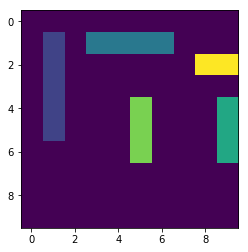

In [9]:
grille = Grille()
grille.genere_grille()
grille.affiche()

## 2 Combinatoire du jeu

Donner une borne supérieure du nombre de configurations possibles pour la liste
complète de bateaux sur une grille de taille 10 (calcul à la main).

In [84]:
# fonction qui permet de dénombrer le nombre de façons de placer un bateau donné sur une grille vide
def how_many_ways_to_put(grid, ship_len, lines):
    """
        Assumption: the grid is represented as a SQUARE matrix
        
        @params: grid 
                 ship_len -> longueur du bateau 
                 lines -> number of lines in the grid
    """
    assert(isinstance(grid, Grille))
    assert(isinstance(ship_len, int) and ship_len > 0)
    
    #grid = Grille(lines, lines)
    count = 0
    Bateau['temp'] = [ship_len, 100]
    
    for i in range(lines):
        for j in range(lines):
            if grid.peut_placer('temp', (i,j), Direction.horizontal):
                count += 1
            
            if grid.peut_placer('temp', (i,j), Direction.vertical):
                count += 1
    
    del Bateau['temp']
    
    return count

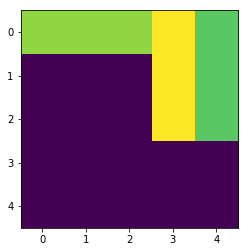

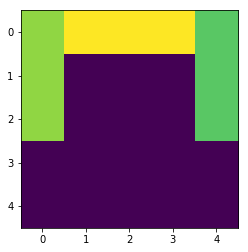

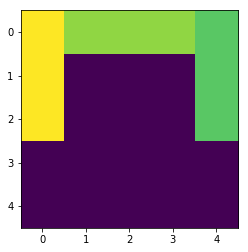

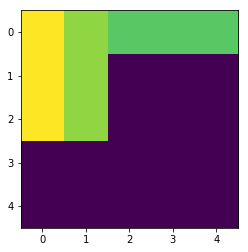

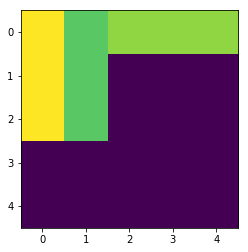

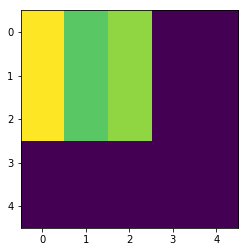

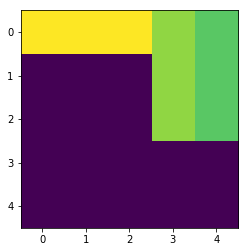

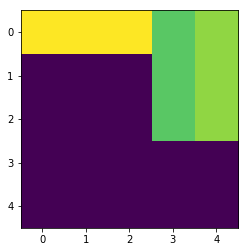

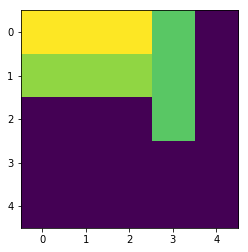

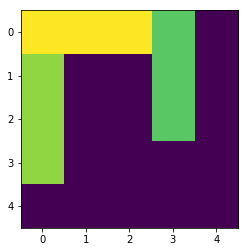

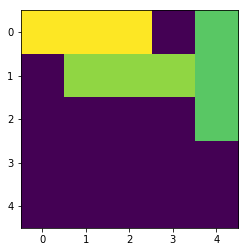

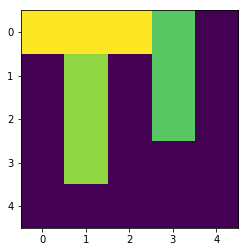

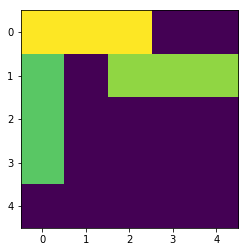

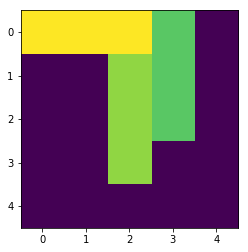

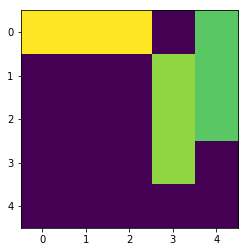

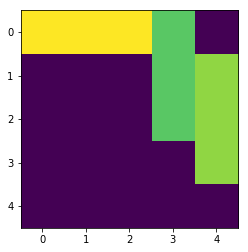

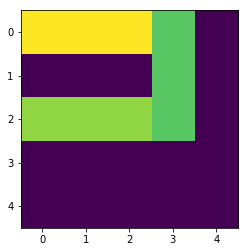

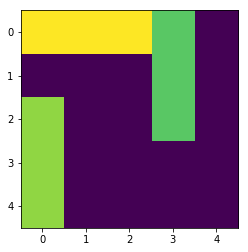

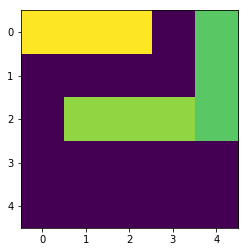

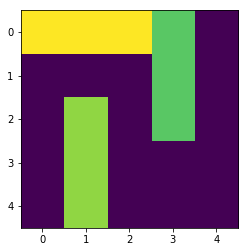

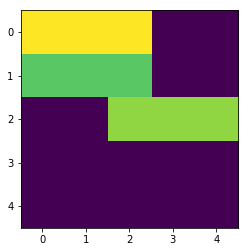

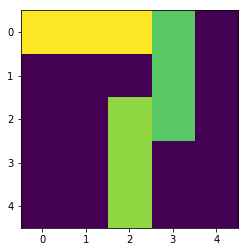

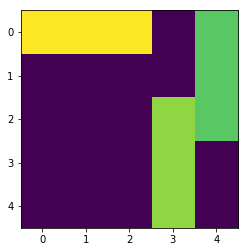

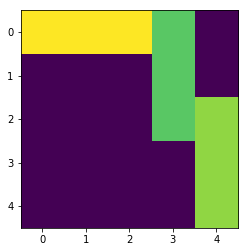

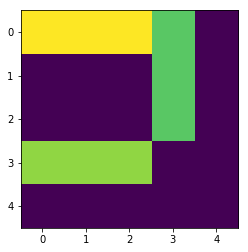

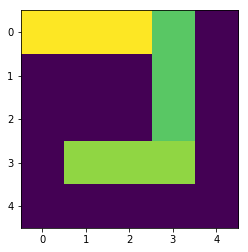

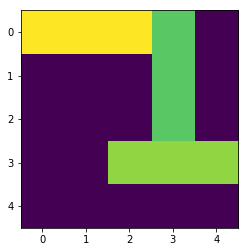

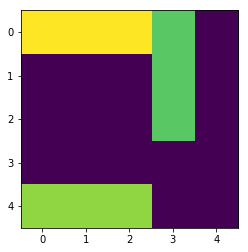

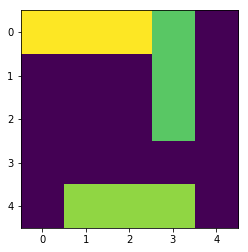

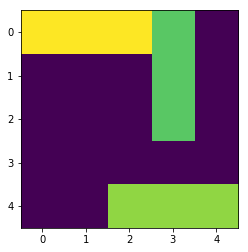

30

In [122]:
from matplotlib.pyplot import show
def try_put_ship(grid, ship):
    # returns the direction and position
    
    for i in range(grid.lines):
        for j in range(grid.cols):
            for direction in Direction:
                if grid.peut_placer(ship, (i,j), direction):
                    return ((i,j), direction)
                
    return False

# fonction qui permet de dénombrer le nombre de façon de placer une liste de bateaux sur une grille vide. 
def how_many_conf(ships_length, lines):
    """
        Assumption: the grid is represented as a SQUARE matrix
        
        @params:
            - ships_length -> a list of int in which each int (ship's length) > 0
            
    """
    count = 0

    # constructing ships
    ships = []
    for ship_len in ships_length: 
        color = np.random.randint(1,200)
        ship_name = str(ship_len + color) + 'D' + str(ships_length.count(ship_len))
        ships.append(ship_name)
        Bateau[ship_name] = [ship_len, color]
        
    # constructing configurations
    
    for i in range(lines):
        for j in range(lines):
            for direction in Direction:
                grid = Grille(lines, lines)
                
                if grid.place(ships[0], (i,j), direction):
                    all_true = []
                    #print(grid.grille)
                    for k in range(1, len(ships)):
                        res = try_put_ship(grid, ships[k])
                        
                        if res is False:
                            break
                            
                        grid.place(ships[k], res[0], res[1])
                        #print(grid.grille)
                        all_true.append(True)
                            
                    if all_true.count(True) == len(ships) - 1:
                        count += 1
                        grid.affiche()
                        show()
    
    # deleting ships from dictionnary

    for ship in ships:
        try:
            del Bateau[ship]
        except KeyError:
            pass
    
    return count
        
how_many_conf([3,3,3], 5)